<a href="https://colab.research.google.com/github/tonigarrett2023/FinalProject/blob/main/Prototype_with_resnet50_iter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import the necessary packages

import numpy as np
import tensorflow as tf

from keras.optimizers import SGD
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization, AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import os
import pandas as pd
import glob
import time
import random
import cv2

In [ ]:

from google.colab import drive
drive.mount('/content/drive/')



In [ ]:
path = "/content/drive/MyDrive/Final_Project/Hyperkvasir_labeled_images/upper_lower_gi_tract"

## Data preprocessing

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

train_dataset = tf.keras.utils.image_dataset_from_directory(path,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=True,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=42)

validation_dataset = tf.keras.utils.image_dataset_from_directory(path,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=True,
                                                                 validation_split=0.2,
                                                                 subset="validation",
                                                                 seed=42)

Found 10662 files belonging to 23 classes.
Using 8530 files for training.
Found 10662 files belonging to 23 classes.
Using 2132 files for validation.


## Visualising the first nine images from the training set

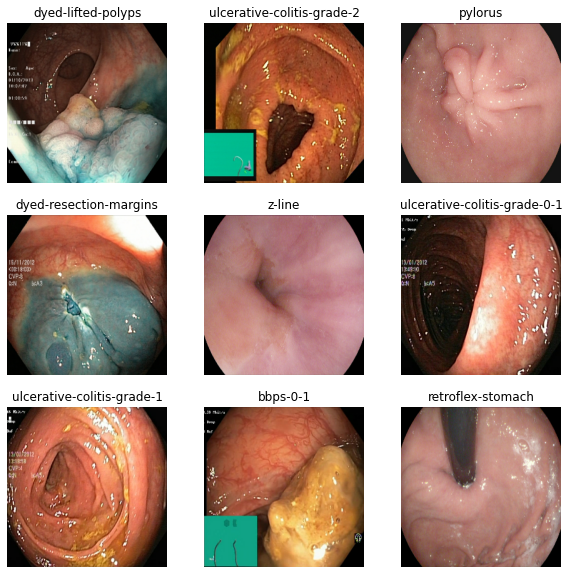

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 45
Number of test batches: 22


## Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation to help with overfitting 
 - displaying what the augmented image looks like

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.3),
  tf.keras.layers.RandomBrightness([-0.8,0.8]),
  tf.keras.layers.RandomContrast(0.2)
])

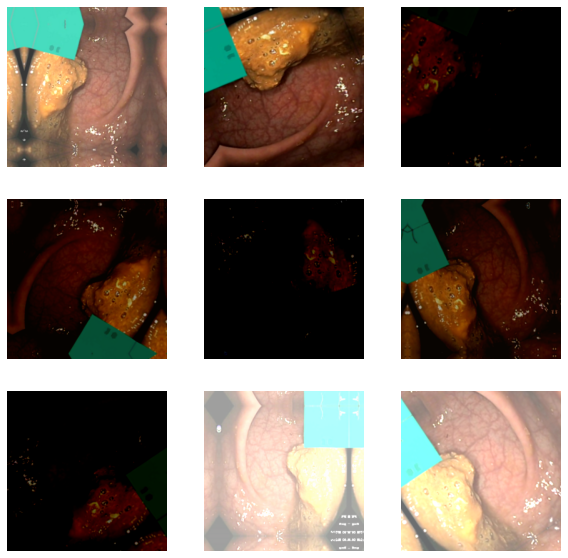

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0),training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Rescaling pixel values

In [ ]:
preprocess_input_resnet = tf.keras.applications.resnet50.preprocess_input
preprocess_input_inception = tf.keras.applications.inception_v3.preprocess_input

# ResNet50

## Creating the base model from pre-trained weights
 - excludes the classification layers at the top which is ideal for feature extraction

In [ ]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(256, 256, 3))

## Freeze the base model

In [ ]:
base_model.trainable=False


## Build the model using augmented data, rescaled pixel values and the base model and feature extractor layers 

In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256,256,3)),
        data_augmentation,
        tf.keras.layers.Lambda(preprocess_input_resnet),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(23, activation='softmax')
    ])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

## Compile and train the model 

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


267/267 [==============================] - 1326s 5s/step - loss: 2.1361 - accuracy: 0.3719 - val_loss: 1.0446 - val_accuracy: 0.7038
Epoch 2/10
267/267 [==============================] - 102s 380ms/step - loss: 1.3187 - accuracy: 0.5965 - val_loss: 0.7785 - val_accuracy: 0.7745
Epoch 3/10
267/267 [==============================] - 100s 371ms/step - loss: 1.1011 - accuracy: 0.6508 - val_loss: 0.6152 - val_accuracy: 0.8095
Epoch 4/10
267/267 [==============================] - 101s 375ms/step - loss: 0.9945 - accuracy: 0.6841 - val_loss: 0.5975 - val_accuracy: 0.8200
Epoch 5/10
267/267 [==============================] - 101s 373ms/step - loss: 0.9307 - accuracy: 0.6962 - val_loss: 0.5627 - val_accuracy: 0.8214
Epoch 6/10
267/267 [==============================] - 99s 368ms/step - loss: 0.8794 - accuracy: 0.7115 - val_loss: 0.5618 - val_accuracy: 0.8277
Epoch 7/10
267/267 [==============================] - 99s 368ms/step - loss: 0.8281 - accuracy: 0.7271 - val_loss: 0.5026 - val_accuracy: 

## Visualise the training and validation accuracies

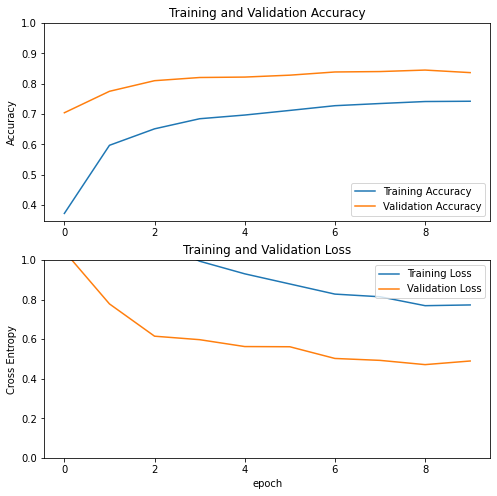

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning
 - unfreeze the base model and set the bottom layers to be untrainable

In [ ]:
base_model.trainable = True

In [ ]:
# How many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


## Compile and continue training the model

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


267/267 [==============================] - 132s 461ms/step - loss: 0.9183 - accuracy: 0.6943 - val_loss: 0.4847 - val_accuracy: 0.8340
Epoch 11/20
267/267 [==============================] - 124s 459ms/step - loss: 0.7359 - accuracy: 0.7543 - val_loss: 0.4393 - val_accuracy: 0.8473
Epoch 12/20
267/267 [==============================] - 123s 456ms/step - loss: 0.6687 - accuracy: 0.7717 - val_loss: 0.4238 - val_accuracy: 0.8564
Epoch 13/20
267/267 [==============================] - 123s 456ms/step - loss: 0.6307 - accuracy: 0.7846 - val_loss: 0.3985 - val_accuracy: 0.8564
Epoch 14/20
267/267 [==============================] - 123s 456ms/step - loss: 0.6093 - accuracy: 0.7959 - val_loss: 0.3882 - val_accuracy: 0.8732
Epoch 15/20
267/267 [==============================] - 123s 456ms/step - loss: 0.5802 - accuracy: 0.8080 - val_loss: 0.4034 - val_accuracy: 0.8690
Epoch 16/20
267/267 [==============================] - 122s 455ms/step - loss: 0.5467 - accuracy: 0.8166 - val_loss: 0.3772 - val_

## Visualise the performance after some fine-tuning

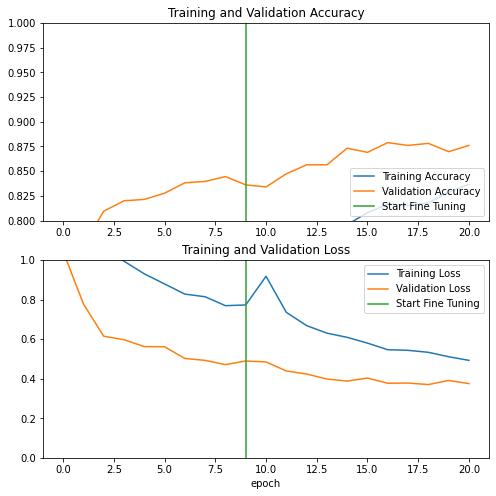

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and Prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

22/22 [==============================] - 4s 131ms/step - loss: 0.4076 - accuracy: 0.8693
Test accuracy : 0.8693181872367859


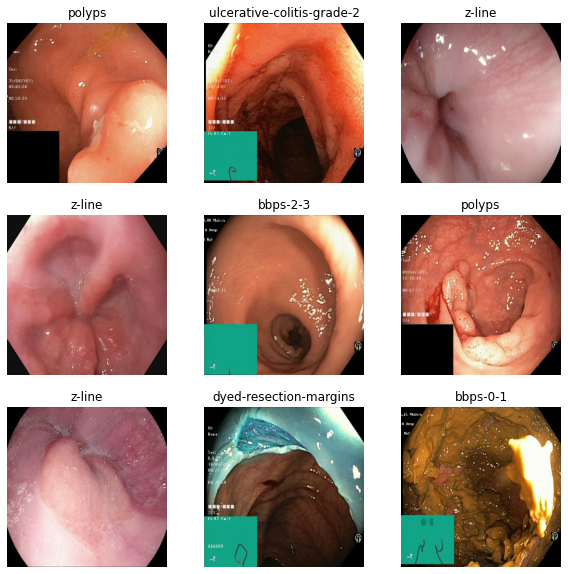

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
prediction = model.predict_on_batch(image_batch)

predictions = []

# Last layer of model is softmax: take the maximum to predict
for arr in prediction:
  predictions.append(np.argmax(arr))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# InceptionV3

## Create the base model 

In [ ]:
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False, 
    input_shape=(256, 256, 3))

base_model.trainable=False

model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256,256,3)),
        data_augmentation,
        tf.keras.layers.Lambda(preprocess_input_inception),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

model.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 lambda_2 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               

In [ ]:
# Compile and Train the model

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


267/267 [==============================] - 98s 337ms/step - loss: nan - accuracy: 0.0039 - val_loss: nan - val_accuracy: 0.0028
Epoch 2/10
267/267 [==============================] - 88s 327ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0028
Epoch 3/10
267/267 [==============================] - 88s 325ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0035
Epoch 4/10
267/267 [==============================] - 88s 327ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0028
Epoch 5/10
267/267 [==============================] - 88s 326ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0035
Epoch 6/10
267/267 [==============================] - 88s 327ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0021
Epoch 7/10
267/267 [==============================] - 88s 325ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0035
Epoch 8/10
267/267 [==================

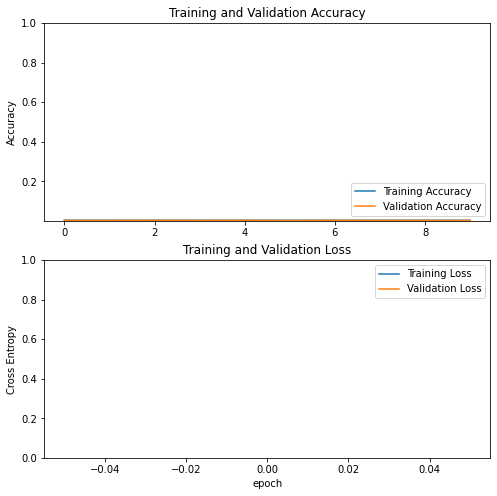

In [ ]:
# Visualise the performance of InceptionV3

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning 

In [ ]:
base_model.trainable = True

# How many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


267/267 [==============================] - 123s 426ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0035
Epoch 11/20
267/267 [==============================] - 113s 419ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0028
Epoch 12/20
267/267 [==============================] - 114s 422ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0042
Epoch 13/20
267/267 [==============================] - 113s 419ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0035
Epoch 14/20
267/267 [==============================] - 113s 419ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0028
Epoch 15/20
267/267 [==============================] - 113s 419ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0021
Epoch 16/20
267/267 [==============================] - 112s 417ms/step - loss: nan - accuracy: 0.0038 - val_loss: nan - val_accuracy: 0.0021
Epoch 17/20
267/267 [====

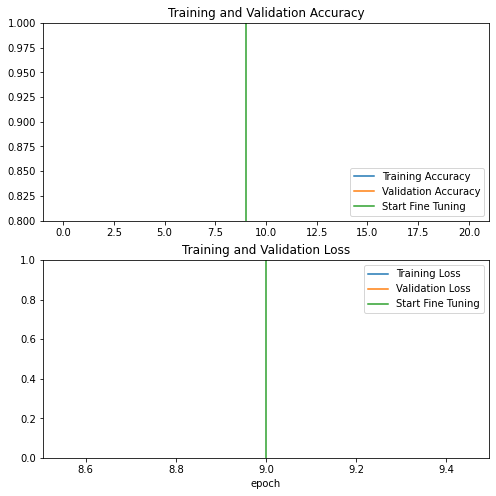

In [ ]:
# Visualise performance after fine tuning

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and Prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

22/22 [==============================] - 4s 135ms/step - loss: nan - accuracy: 0.0071
Test accuracy : 0.007102272938936949


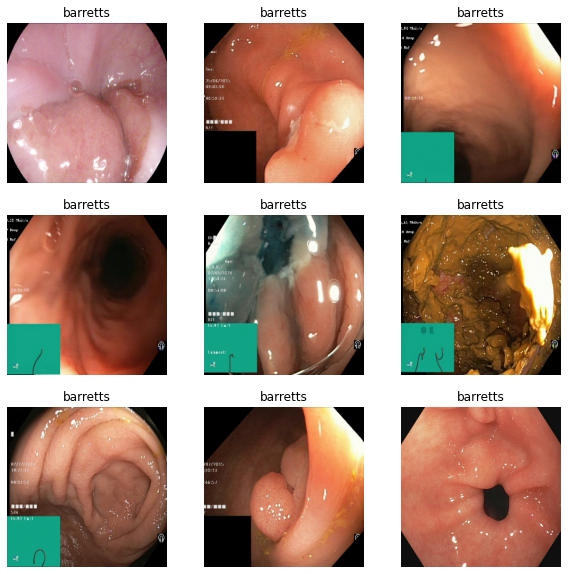

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
prediction = model.predict_on_batch(image_batch)

predictions = []

# Last layer of model is softmax: take the maximum to predict
for arr in prediction:
  predictions.append(np.argmax(arr))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")